# CADA Team Null Analysis: NYC MoMA Collections Data
<a href="https://www.museum-mgmt.com/" target="_blank"><img src="MMM_Logo_Bk.svg" width="30%"/></a>

<div style="background-color:gray; width:1%; margin:auto; margin-bottom:20px; margin-top:0px;"></div>

<section id="intro">
    <h2>Introduction</h2>
</section>
Hello and welcome to the first analysis in a series of three analyses produced by the CADA team at Mountain Museum Management (MMM). This analysis primarily focuses on reporting on the museum's collection's data integrity, especially with the intent of pursuing further collections analysis and forecasting. This report is a demonstration intended for MMM clients to have a tangible example of how their expertise is integrated into decisions that are made in analytical work. The team shares broader goals of raising data literacy and algorithmic transparency for the benefit of all museum professionals. We operate on the principle: "if we can't gut-feel it, then it's not on the table." Meaning that we only advocate for solutions that we stand behind 100%, and if something doesn't feel right, we will make it right!<br><br>

For the sake of future client interpretability and replicability, I will walkthrough and explain the observations and thought process motivating each step in the analysis. Full disclosure for anyone curious, not all noted observations can be considered relevant to the final reports conclusions so it's possible that some observations will not be made explicit in the final report, however they are only excluded for brevity and not discarded from consideration.
<br><br>
The overall goal of this analysis series is to provide MMM clients with a tangible example of the process of forecasting collections growth in quantity, space-use, and cost, as well as pay our learning forward to any aspiring museum // data professionals looking for documentation of such an undertaking.<br><br><br>*All data has been provided and maintained for free since 2016, courtesy of the NYC Museum of Modern Art (MoMA).*
<br><br>

___
<section id="toc">
    <h2>Table of Contents</h2>
    <ol>
        <li><a href="#intro">Introduction</a></li>
        <li><a href="#load-libaries">Load Libraries</a></li>
        <li><a href="#define-funcs">Defining Data QA Functions</a></li>
        <li><a href="#load-data">Load Data</a></li>
        <li><a href="#data-valid">Data Validation</a></li>
        <li><a href="#define-qa">Define Data Quality</a></li>
        <li><a href="#nvr-comps">Null-Value Replacement Strategy Comparisons</a></li>
        <li><a href="#conclusions">Conclusions & Recommendations</a></li>
    </ol>
</section>

___

### Our Objective
Identify and address null values within the museum's collections dataset to increase confidence in downstream analytical reporting and forecasting processes. This is step (1) of (3) total steps for museum collections forecasting over time.<br>
At this stage in the analysis, recommendations can be made for picking a proper dataset for further analysis and any data entry process adjustments that can be identified throughout the data cleaning process, ideally making data entry work faster, more accurate, and less overhead on staff.

Our secondary and broader objective is to identify and interpret museums collections practices through a sociotechnical perspective, or in other words, putting organizational practices into informational (data) terms. In the event there is ever conflict during such a process, we respect and prioritize the local knowledges of our clients over the standardizing practices of data work. We offer standardization as one of any number of services which are intended for making data work easier on all workers involved, but our team understands data work to be a subset of an organization's overall work, rather than the culmination of it. Our team has firsthand experience in data entry roles, we acknowledge that it's a process that is notorious for being tedious and is well-known to take large tolls on worker energy and mental health. Together, Samantha and I, have set out to find and describe the common ground between museum collections practices and socially-aware data collection practices to better delineate between what data practices are of interest to the client specifically and to the field of museum collections generally. 

The product of this analysis is a comprehensive report on the data integrity (read: health) of the NYC MoMA Artworks dataset, which culminates in a chosen dataset considered to be fit for proceeding on with analysis and forecasting.  

### Our Team
- Samantha Hunt-Durán (she / her): Museum professional with +10 years of experience. 
- Marisol Yake (she / they): Data analyst consultant with +3 years of experience.

Sam hired me (Marisol) for this pilot project, and I recommended these analysis prototypes to make our data cleaning decisions transparent for our client's benefit and future reference.

### Our Methods
- Human-Centered Design - Emphasis on client autonomy in data work and decision-making transparency.
- Exploratory Analysis - Comprehensive exploration of relationships in a given dataset. Supports future analysis & forecasting.
- Time Series Analysis & Forecasting - A set of data science methods for describing and predicting trends in data over time.
<br><br>

<section id="load-libaries">
    <h2>Load Libraries</h2> 
</section>

Here, I will be loading all python data science libraries that will be necessary for completing the following analysis. Each of these libraries contain commonly-used functions which make data visualization and analysis much faster than building each function from scratch. Aside from *etl*, all of the libraries are open-source and in popular use amongst data scientists. The *etl* library is a bespoke python script, written by Marisol, which centralizes documention for all data handling and cleaning processes while also having the added benefit of reducing the amount of code as visual noise in this report.

In [2]:
import warnings  # Suppresses non-breaking bug warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from IPython.display import display  # pretty results
import os  # file-handling
import pandas as pd  # data-manipulation
import seaborn as sns  # data visualization
import matplotlib.pyplot as plt  # data visualization
import etl  # MMM software for bespoke collections data cleaning

pd.options.mode.chained_assignment = None
pd.options.display.float_format = ("{:.3f}".format)  # prevent converting numbers to scientific notation, rounds up to the 100ths decimal place
pd.set_option("display.width", 1000)
sns.set_style("whitegrid")

<section id="define-funcs">
    <h2>Data Quality Inspection Functions</h2>
</section>

All of these functions help to facilitate a human-friendly output format when inspecting the dataset's qualities (not focusing on content quite yet).

In [3]:
# File Diagnostic Functions - Will move to external script eventually
def print_file_dimensions(df):
    categorical_cols, numerical_cols = split_columns_by_type(df)
    print("*** Dataset Dimensions ***")
    print("Shape:", df.shape)
    print("Number of Numerical Columns:", len(numerical_cols))
    print("Numerical Columns:", list(numerical_cols), "\n")
    print("Number of Categorical Columns:", len(categorical_cols))
    print("Categorical Columns:", list(categorical_cols), "\n\n")

def plot_null_values(df, title, export = False, ax = None):
    """Generates a plot visualizing all null values. Offers optional exporting and subplotting."""
    title = title.strip().replace("-", " ").title()
    # ref: https://stackoverflow.com/questions/32244753/how-to-save-a-seaborn-plot-into-a-file
    fig = (
        sns.heatmap(df.isnull().T, cbar=False, ax = ax)
        .set_title(title)
        .get_figure()
    )

    if export:
        save_plots(fig, fig_title, file_name)

def save_plots(fig, fig_title, file_name, png=True, pdf=True):
    """Save plots to PDF or PNG image file formats."""
    plot_title = f"{fig_title.replace(' ', '_')}-{file_name.replace(' ', '_')}"
    if png:
        fig.savefig(f"./out/viz/{plot_title}.png", dpi=fig.dpi, bbox_inches="tight")
    if pdf:
        fig.savefig(f"./out/viz/{plot_title}.pdf", dpi=fig.dpi, bbox_inches="tight")

def split_columns_by_type(df):
    """Columns are split into Categorical and Numerical groupings."""
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    num_cols = df.select_dtypes(exclude=["object", "category"]).columns
    return cat_cols, num_cols

<section id="load-data">
    <h2>Load all data</h2>
</section>

In this section, we declare where the dataset(s) live before loading the artworks collection dataset file into our etl (extract-transform-load) script. After running our custom etl program, it will output ($4$) datasets which conform to expectations that were ironed out during the course of several on-boarding and analysis meetings. We carefully discussed the overall project requirements, which columns are considered in-scope for this project, and how to proceed with handling missing data. The agreed upon processes are written as-plainly-as-possible within the `etl.py` script for transparency, thorough documentation, and to reduce the overall length of this analysis notebook.

The outputs of `etl.clean_data(file_path)` in this case are 4-fold: 
1. "Clean Prefill Dataset": Explanation of the dataset
2. "Drop All Nulls": Explanation of the dataset
3. "Department Average Spatial Fill": Explanation of the dataset
4. "Storage Group Average Spatial Fill": Explanation of the dataset

By the end of this analysis, we will decide which one of these collections dataset variations are appropriate for further analysis & forecasting. 

In [4]:
data_path = "./data/"
file_name = "MoMA NYC artworks.csv"
file_title = file_name.split(".")[0]
file_path = os.path.join(data_path, file_name)

# Loading in all datasets for comparison
loaded_data = etl.clean_data(file_path)
datasets = {
    "clean-prefill-dataset": loaded_data[0].copy(),
    "drop-all-nulls-dataset": loaded_data[1].copy(),
    "dept-avg-fill-dataset": loaded_data[2].copy(),
    "storage_group-avg-fill-dataset": loaded_data[3].copy(),
}

<section id="data-valid">
    <h2>Data Validation</h2>
</section>

Without an active client relationship for this project, we elected to lean on Samantha's experiences as a collections professional. She has kindly offered her expertise on collections quality assessment and through the course of several meetings, we arrived at a synthesis of Collections & Data quality assessment priorities. Each new collection we work with will merit revisting our chosen Data QA priorities, which in turn will reinforce our understanding of museum data work priorities in the field more broadly. Our application of data validation prioritizes a client's knowledge and practices over data work best practices, as data work is only a subset of an organization's work.   

<a href="https://www.kaggle.com/datasets/momanyc/museum-collection?select=artworks.csv">Original Data Source</a><br>
This dataset, originally uploaded in 2016, is made publicly available on Kaggle under the <strong>CC0: Public Domain</strong> license courtesy of the NYC Modern Museum of Art (NYC MoMA) and Abigail Larion.
<br><br>
Additional documentation used to make this analysis possible:<br>
<a href="https://www.moma.org/momaorg/shared/pdfs/docs/about/Collections-Management-Policy-2020-04-20.pdf">NYC MoMA Collections Management Policy</a> - For clarifying ambiguous translations of record-keeping to data entry practices.<br>
<a href="https://github.com/MuseumofModernArt/collection">NYC MoMA Collections Data Github Repository</a> - For validating data fields and ambiguous data.<br>
<a href="https://www.moma.org/about/mission-statement/history">NYC MoMA Collections History</a> - For historical context of collections growth.<br>
<a href="https://www.sbctc.edu/resources/documents/colleges-staff/commissions-councils/dgc/data-quality-deminsions.pdf">Washington State Community and Technical Colleges</a> - For guidelines on considerations for data quality assessment.

<section id="define-qa">
    <h2>Defining Data Quality</h2>
</section>

According to the *THE SIX PRIMARY DIMENSIONS FOR DATA QUALITY ASSESSMENT* written by the Washington State Community and Technical Colleges, there are 6 primary dimensions up for consideration in data quality assessment which must be weighed on a case-by-case basis. Which of the dimensions of data quality to emphasize depends on the organizations' size, resources, requirements, levels of risk, and so on. Each of the data quality assessments are applied, gathering examples of data that do and don't conform to one or more requirements. 

Samantha and I have met together several times to discuss this analysis in-depth. We have covered requirements for the overall analysis, data dimensions of concern, what the dataset records are meant to represent. Using the definitions provided in the *THE SIX PRIMARY DIMENSIONS FOR DATA QUALITY ASSESSMENT*, I will outline each of the dimensions below before making a professional recommendation.

### Data Quality Dimensions:

[ Explain how Sam and I got to this point! ]<br>
[ "Why are these dims important at all?" ]<br>
[ "How many meetings did it take?" ]<br>
[ "Is the Data QA dim relevant to client, field, or data?", using my meeting notes to answer. ]<br>


Listed by order of priority:
**Completeness:** The proportion of stored data against the potential of "100% complete."<br>
**Uniqueness:** No thing will be recorded more than once based upon how that thing is identified.<br>
**Timeliness:** The degree to which data represent reality from the required point in time.<br>
**Validity:** Data are valid if it conforms to the syntax (format, type, range) of its definition.<br>
**Accuracy:** The degree to which data correctly describes the "real world" object or event being described.<br>
**Consistency:** The absence of difference, when comparing two or more representations of a thing against a definition.<br>


After careful assessment of these Data QA definitions and the client's professional interpretation of the requirements, I have produced a graphic representing my specific recommendations regarding the NYC MoMA's Data Quality Dimension Assessment Priorities:
<center><img src="./out/DataQA_6Dims.png" width="50%"/></center>

<section id="nvr-comps">
    <h2>Null-Value Replacement Strategy Comparisons</h2>
</section>
Visualizing differences in data quality, integrity, and analytical outcomes. Where feasible, I have set the results to print out side-by-side for ease-of-comparison between all of the datasets. Any of the results which were printed top-to-bottom will be edited and arranged to be side-by-side before we add them to the final reports.
<br><br>

[ What does this view tell us? ]
- [ The total number of records and columns in the dataset ]<br>
- [ General indication of the presence of null values ]<br>
- [ Data types in the dataset ]<br>
- [ All column names in the dataset ]<br>
- [ The exact amount of memory (RAM) a dataset takes up. Has to do with shape (wide/long) ]<br>

In [5]:
# Comparing data integrity by approved null value fill strategies
for file in datasets:
    # print("*" * 150)
    print("Dataset:", file.replace("-", " ").title())
    print()
    datasets[file].info()
    print()
    print()

Dataset: Clean Prefill Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 130262 entries, 55947 to 129943
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   artwork_id             130262 non-null  int64          
 1   artist_id              128802 non-null  object         
 2   date                   126757 non-null  datetime64[ns] 
 3   acquisition_date       130262 non-null  datetime64[ns] 
 4   credit                 127192 non-null  object         
 5   catalogue              130262 non-null  object         
 6   department             130262 non-null  object         
 7   classification         130262 non-null  object         
 8   object_number          130262 non-null  object         
 9   credit_group           130262 non-null  object         
 10  storage_group          130262 non-null  object         
 11  height_ft              111893 non-null  float64        
 12 

Worth noting that the number of records (or rows) is not equal for all of the datasets. The `Drop All Nulls Dataset` only contains $9,776$ records, in contrast to the `Clean Prefill Dataset` (aka the cleaned NYC MoMA artworks dataset, or the original source of truth). Both the `Department Average Fill` and `Storage Group Average Fill` datasets preserve the original dataset record counts, clocking in at $130,262$ records total.

In [6]:
# Comparing total missing values by column
print("Total Missing Values by Column")
print()
null_counts = pd.concat([datasets[file].isna().sum() for file in datasets], 
                        axis = 1, 
                        keys = ["Clean Prefill", "Drop All Nulls", "Dept. Average Fill", "Storage Group Average Fill"])
print(null_counts, sep = "\n\n")
print()

Total Missing Values by Column

                       Clean Prefill  Drop All Nulls  Dept. Average Fill  Storage Group Average Fill
artwork_id                         0               0                   0                           0
artist_id                       1460               0                1460                        1460
date                            3505               0                3505                        3505
acquisition_date                   0               0                   0                           0
credit                          3070               0                3070                        3070
catalogue                          0               0                   0                           0
department                         0               0                   0                           0
classification                     0               0                   0                           0
object_number                      0               0       

In [7]:
# Comparing dataset dimensions and data types
for file in datasets:
    print("Dataset:", file.replace("-", " ").title())
    print()
    print_file_dimensions(datasets[file])

Dataset: Clean Prefill Dataset

*** Dataset Dimensions ***
Shape: (130262, 18)
Number of Numerical Columns: 8
Numerical Columns: ['artwork_id', 'height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum', 'acc_gaps'] 

Number of Categorical Columns: 10
Categorical Columns: ['artist_id', 'date', 'acquisition_date', 'credit', 'catalogue', 'department', 'classification', 'object_number', 'credit_group', 'storage_group'] 


Dataset: Drop All Nulls Dataset

*** Dataset Dimensions ***
Shape: (9776, 18)
Number of Numerical Columns: 8
Numerical Columns: ['artwork_id', 'height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum', 'acc_gaps'] 

Number of Categorical Columns: 10
Categorical Columns: ['artist_id', 'date', 'acquisition_date', 'credit', 'catalogue', 'department', 'classification', 'object_number', 'credit_group', 'storage_group'] 


Dataset: Dept Avg Fill Dataset

*** Dataset Dimensions ***
Shape: (130262, 18)
Number of Numerical Co

Explaining this step as for comprehensive inspection and the results are as-expected. All of the datasets maintain the original $18$ columns. Knowing the difference between categorical and numerical variables is quite handy for setting up future comparisons. Numerical and categorical columns both have different appropriate methods of statistical analysis, so having them separated can make it easier to then recombine them strategically.

[ Although the `date` and `acquisition_date` columns are interpreted in nanoseconds (and thus are numerical), they are com ]

In [8]:
# Descriptive Statistics
for file in datasets:
    # print("*" * 150)
    print("Dataset:", file.replace("-", " ").title())
    display(datasets[file].describe().transpose())
    print()

Dataset: Clean Prefill Dataset


,count,mean,min,25%,50%,75%,max,std
artwork_id,130262.000,82501.372,2.000,34171.250,69541.500,128955.750,218011.000,58124.332
date,126757,1954-06-24 11:53:22.956838656,1768-01-01 00:00:00,1930-01-01 00:00:00,1961-01-01 00:00:00,1979-01-01 00:00:00,2017-01-01 00:00:00,NaN
acquisition_date,130262,1984-08-06 09:33:22.935622016,1929-11-19 00:00:00,1965-11-09 00:00:00,1983-11-30 00:00:00,2007-06-04 00:00:00,2016-12-15 00:00:00,NaN
height_ft,111893.000,1.237,0.000,0.594,0.917,1.458,299.869,1.580
width_ft,111123.000,1.253,0.000,0.584,0.833,1.470,300.000,2.209
depth_ft,12789.000,0.618,0.000,0.000,0.073,0.535,59.333,1.858
cubic_ft,11420.000,37.703,0.000,0.000,0.001,0.383,97194.694,1044.670
spatial_running_total,11420.000,300263.460,5.817,246018.631,341792.667,405186.293,430566.243,123396.825
adate_sum,130262.000,1712.833,1.000,118.000,294.000,889.000,11220.000,3224.740
acc_gaps,130261,0 days 05:51:34.411988238,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,296 days 00:00:00,3 days 15:02:05.911692584



Dataset: Drop All Nulls Dataset


,count,mean,min,25%,50%,75%,max,std
artwork_id,9776.000,124330.194,151.000,81770.750,136648.500,176063.250,217985.000,62554.285
date,9776,1970-07-20 02:30:23.567921434,1768-01-01 00:00:00,1962-01-01 00:00:00,1970-01-01 00:00:00,1990-01-01 00:00:00,2016-01-01 00:00:00,NaN
acquisition_date,9776,1999-08-06 18:50:22.585924736,1930-04-02 00:00:00,1993-10-13 18:00:00,2008-10-08 00:00:00,2012-10-15 00:00:00,2016-12-15 00:00:00,NaN
height_ft,9776.000,1.776,0.000,0.458,1.021,2.188,299.869,3.838
width_ft,9776.000,1.927,0.000,0.541,1.027,2.100,300.000,4.532
depth_ft,9776.000,0.693,0.000,0.000,0.063,0.623,59.333,2.035
cubic_ft,9776.000,44.026,0.000,0.000,0.008,0.748,97194.694,1128.983
spatial_running_total,9776.000,293387.654,5.817,206073.793,341756.509,409700.288,430566.243,130959.654
adate_sum,9776.000,1214.935,1.000,82.000,244.000,876.000,11220.000,1979.166
acc_gaps,9776,0 days 12:01:10.703764320,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,296 days 00:00:00,5 days 18:27:08.338966974



Dataset: Dept Avg Fill Dataset


,count,mean,min,25%,50%,75%,max,std
artwork_id,130262.000,82501.372,2.000,34171.250,69541.500,128955.750,218011.000,58124.332
date,126757,1954-06-24 11:53:22.956838656,1768-01-01 00:00:00,1930-01-01 00:00:00,1961-01-01 00:00:00,1979-01-01 00:00:00,2017-01-01 00:00:00,NaN
acquisition_date,130262,1984-08-06 09:33:22.935622016,1929-11-19 00:00:00,1965-11-09 00:00:00,1983-11-30 00:00:00,2007-06-04 00:00:00,2016-12-15 00:00:00,NaN
height_ft,130262.000,1.272,0.000,0.646,0.958,1.549,299.869,1.489
width_ft,130262.000,1.286,0.000,0.640,0.960,1.591,300.000,2.055
depth_ft,130262.000,0.302,0.000,0.135,0.135,0.172,59.333,0.675
cubic_ft,130262.000,4.813,0.000,0.052,0.133,0.362,97194.694,309.946
spatial_running_total,130262.000,289955.441,0.615,54442.394,251240.632,491149.455,626943.413,205690.070
adate_sum,130262.000,1712.833,1.000,118.000,294.000,889.000,11220.000,3224.740
acc_gaps,130261,0 days 05:51:34.411988238,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,296 days 00:00:00,3 days 15:02:05.911692584



Dataset: Storage_Group Avg Fill Dataset


,count,mean,min,25%,50%,75%,max,std
artwork_id,130262.000,82501.372,2.000,34171.250,69541.500,128955.750,218011.000,58124.332
date,126757,1954-06-24 11:53:22.956838656,1768-01-01 00:00:00,1930-01-01 00:00:00,1961-01-01 00:00:00,1979-01-01 00:00:00,2017-01-01 00:00:00,NaN
acquisition_date,130262,1984-08-06 09:33:22.935622016,1929-11-19 00:00:00,1965-11-09 00:00:00,1983-11-30 00:00:00,2007-06-04 00:00:00,2016-12-15 00:00:00,NaN
height_ft,130262.000,1.221,0.000,0.623,0.937,1.385,299.869,1.475
width_ft,130262.000,1.245,0.000,0.610,0.932,1.417,300.000,2.051
depth_ft,130262.000,0.233,0.000,0.077,0.143,0.155,59.333,0.637
cubic_ft,130262.000,4.091,0.000,0.043,0.109,0.226,97194.694,309.676
spatial_running_total,130262.000,238864.906,0.352,32403.706,202607.397,405617.058,532853.711,175077.069
adate_sum,130262.000,1712.833,1.000,118.000,294.000,889.000,11220.000,3224.740
acc_gaps,130261,0 days 05:51:34.411988238,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,296 days 00:00:00,3 days 15:02:05.911692584


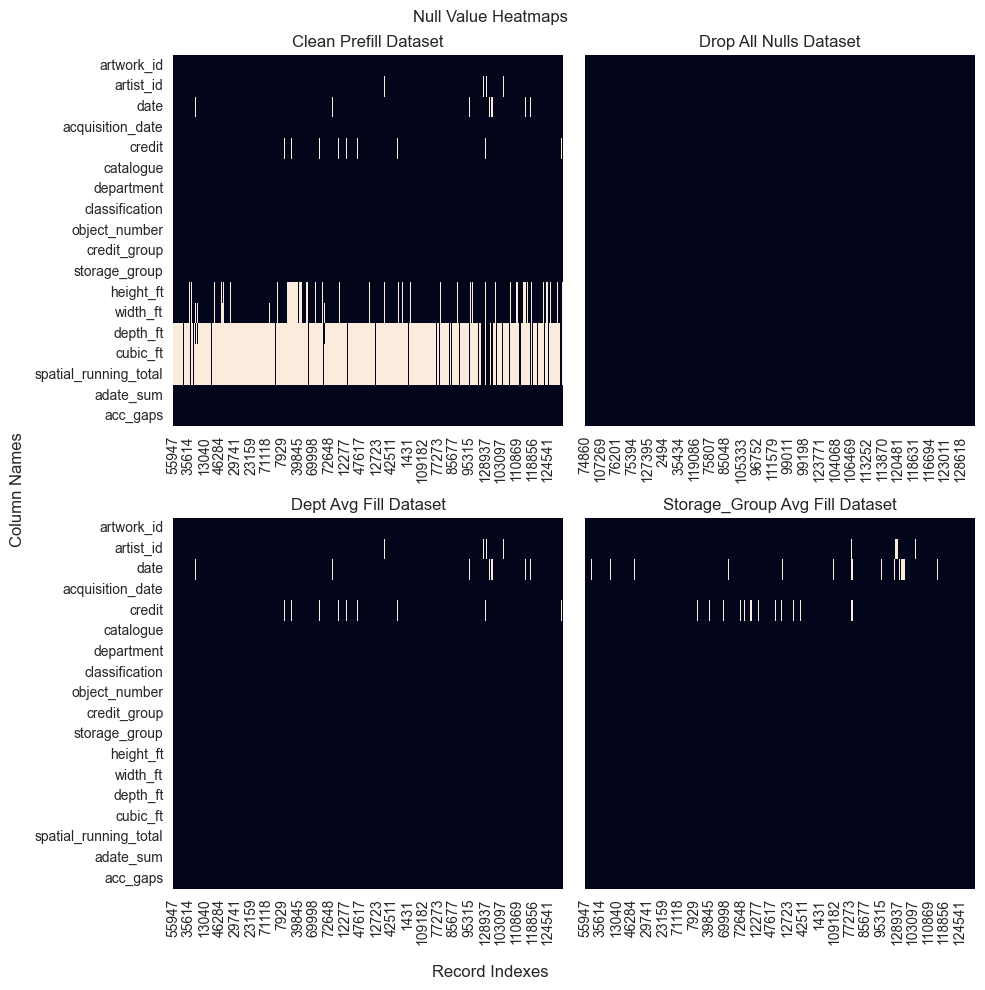

In [9]:
# Null Value Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey = True)

plot_null_values(datasets["clean-prefill-dataset"], "clean-prefill-dataset", export=False, ax = axes[0, 0])
plot_null_values(datasets["drop-all-nulls-dataset"], "drop-all-nulls-dataset", export=False, ax = axes[0, 1])
plot_null_values(datasets["dept-avg-fill-dataset"], "dept-avg-fill-dataset", export=False, ax = axes[1, 0])
plot_null_values(datasets["storage_group-avg-fill-dataset"], "storage_group-avg-fill-dataset", export=False, ax = axes[1, 1])

plt.suptitle("Null Value Heatmaps")
fig.supxlabel("Record Indexes")
fig.supylabel("Column Names")
plt.tight_layout()
plt.show()

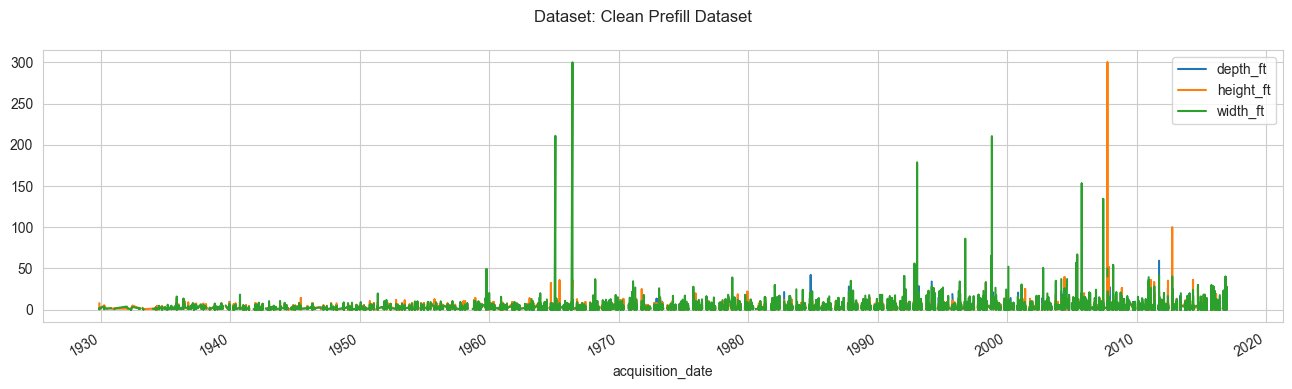

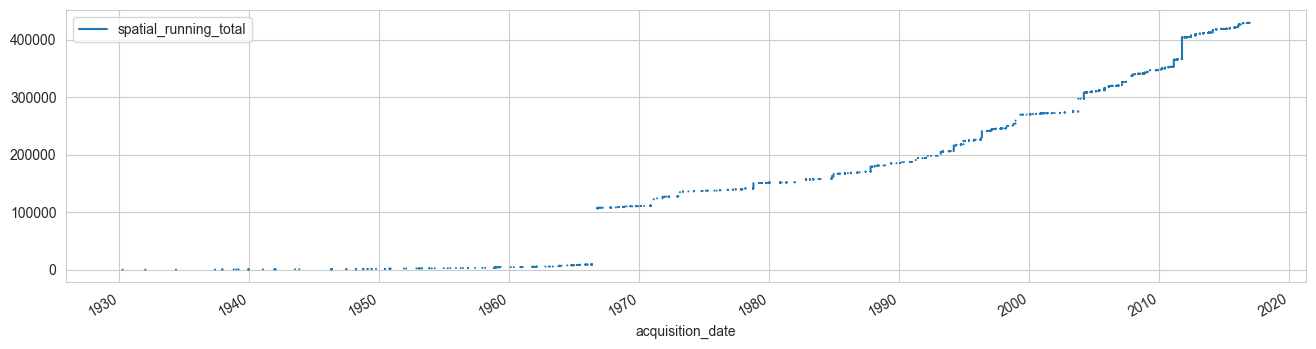

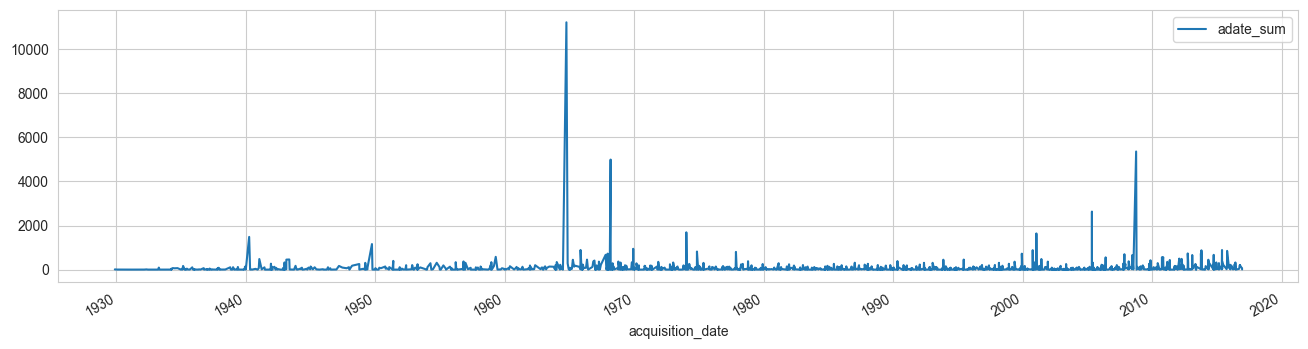

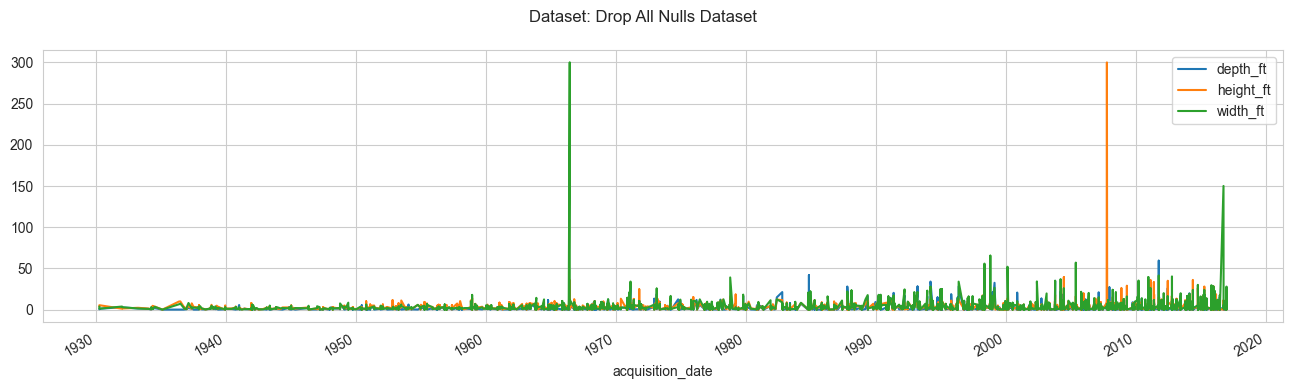

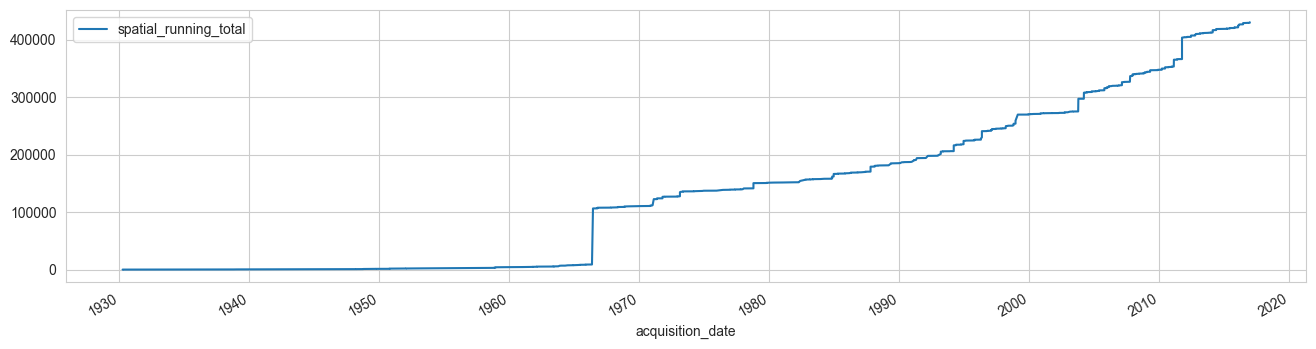

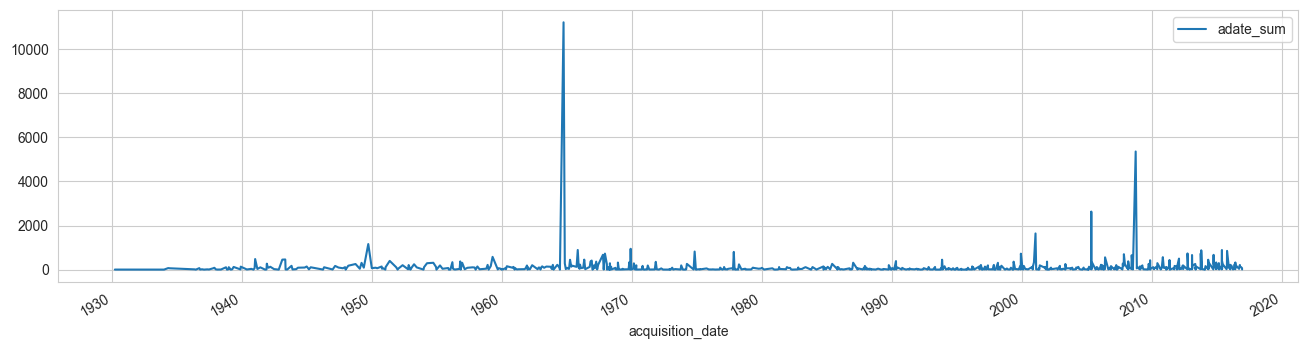

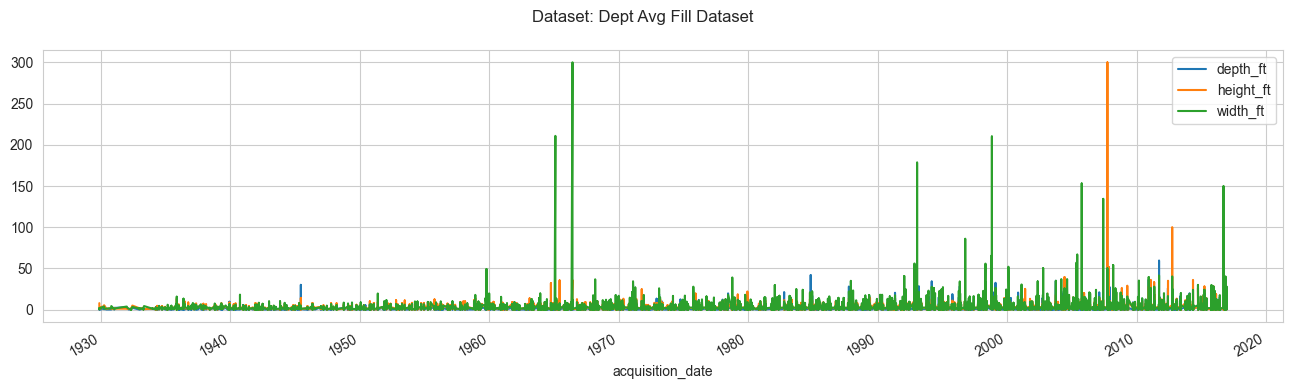

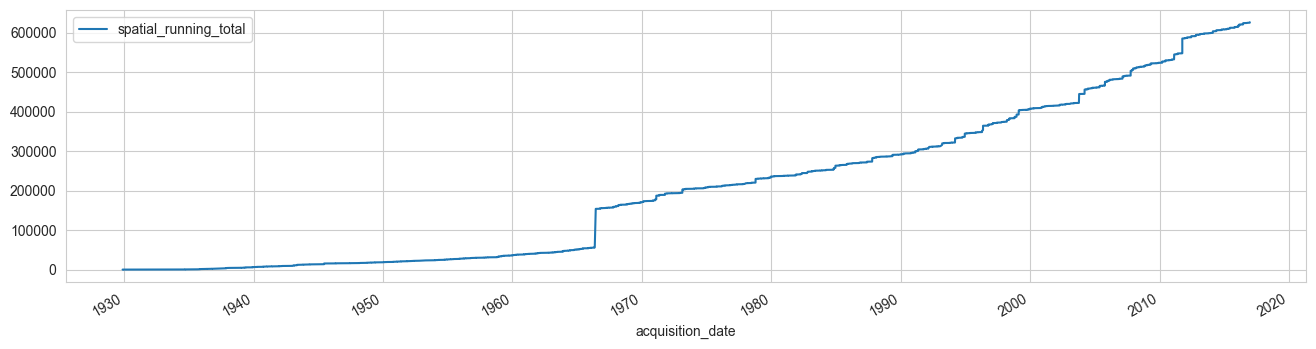

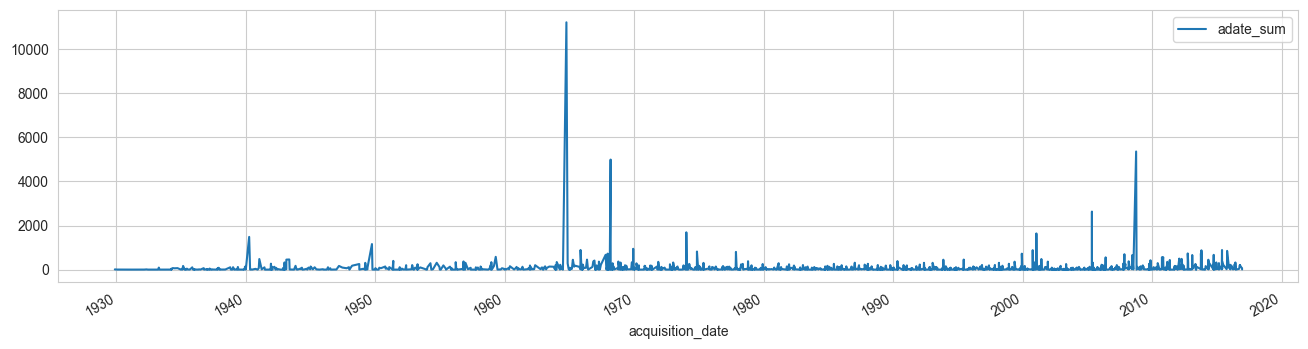

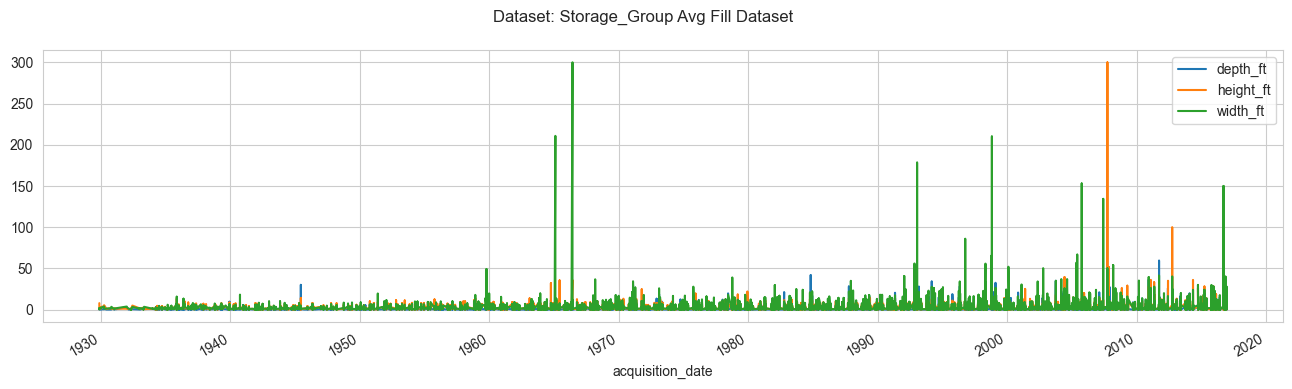

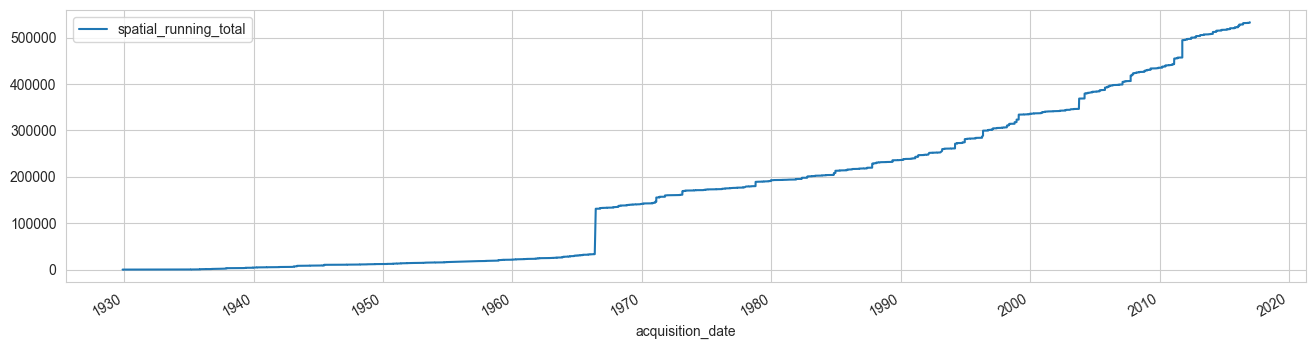

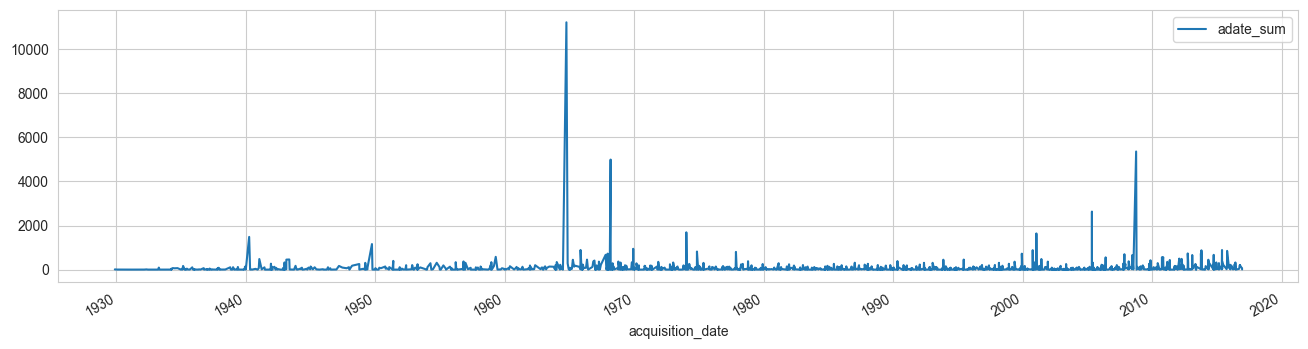

In [11]:
# Line Charts
for file in datasets:
    title = file.replace("-", " ").title()
    datasets[file][["acquisition_date", "depth_ft", "height_ft", "width_ft"]].set_index("acquisition_date").plot(figsize=(16, 4))
    plt.suptitle(f"Dataset: {title}")
    datasets[file][["acquisition_date", "spatial_running_total"]].set_index("acquisition_date").plot(figsize=(16, 4))
    datasets[file][["acquisition_date", "adate_sum"]].set_index("acquisition_date").plot(figsize=(16, 4))
    plt.show()

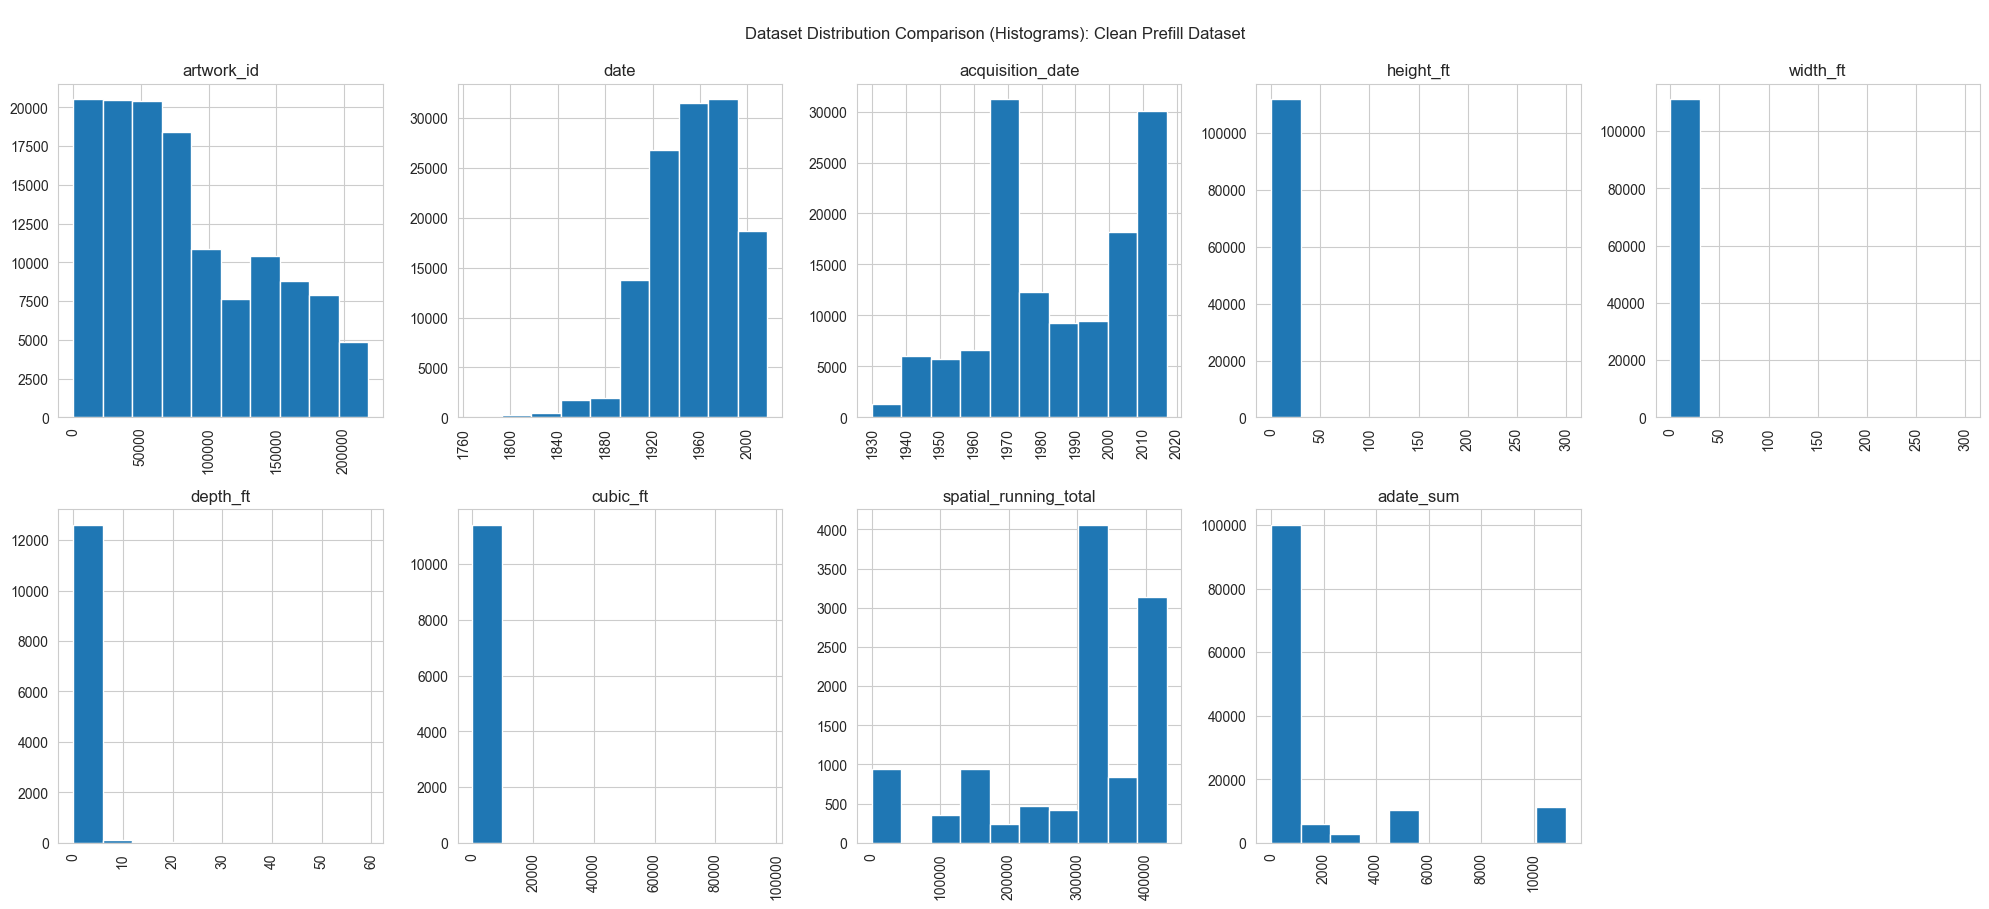

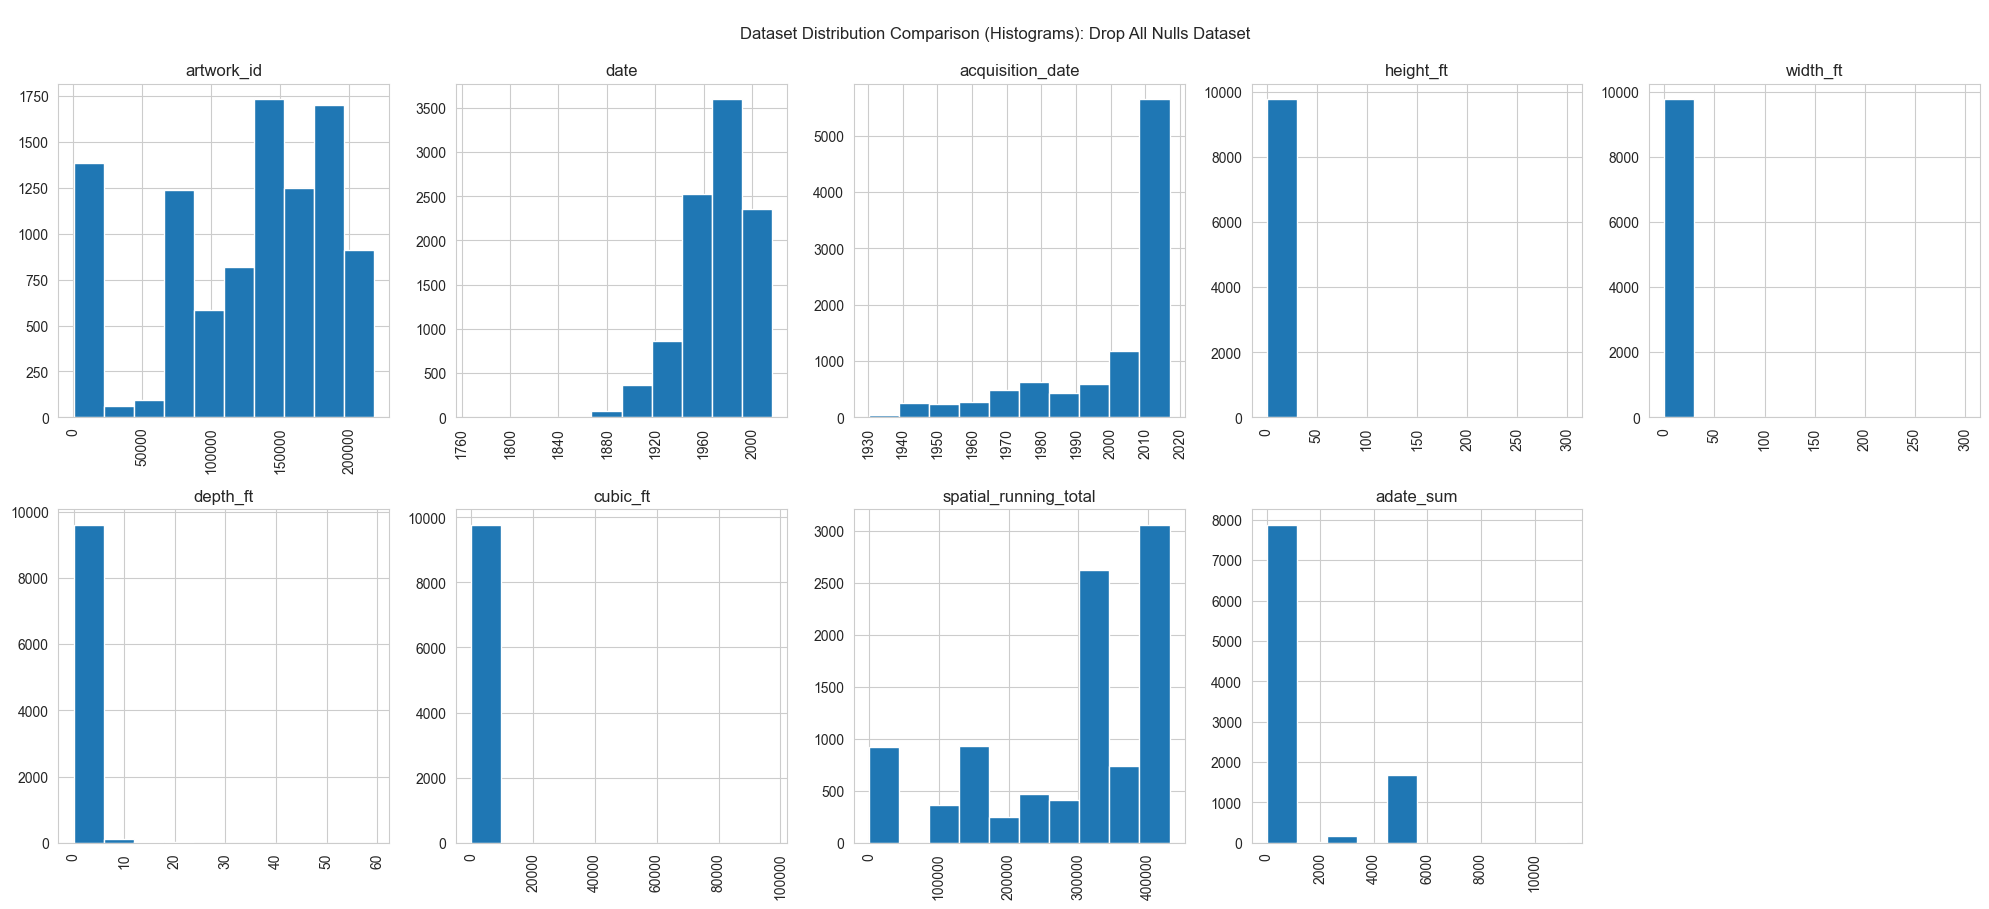

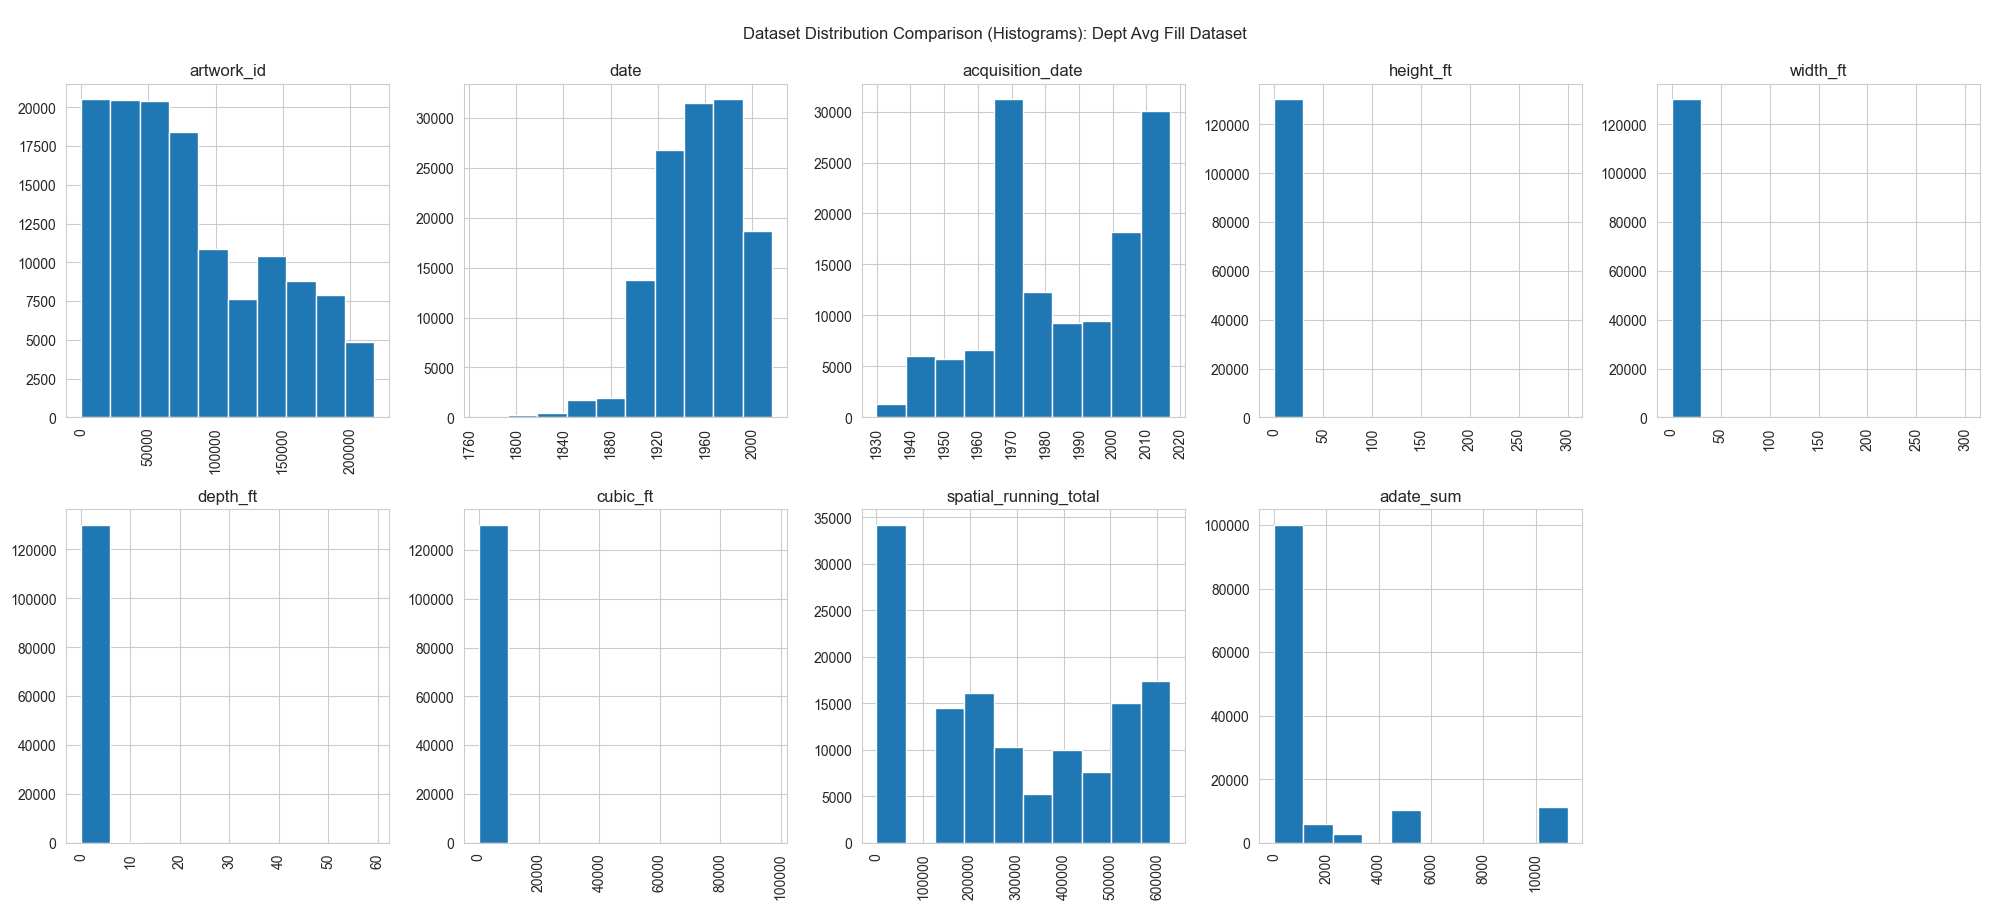

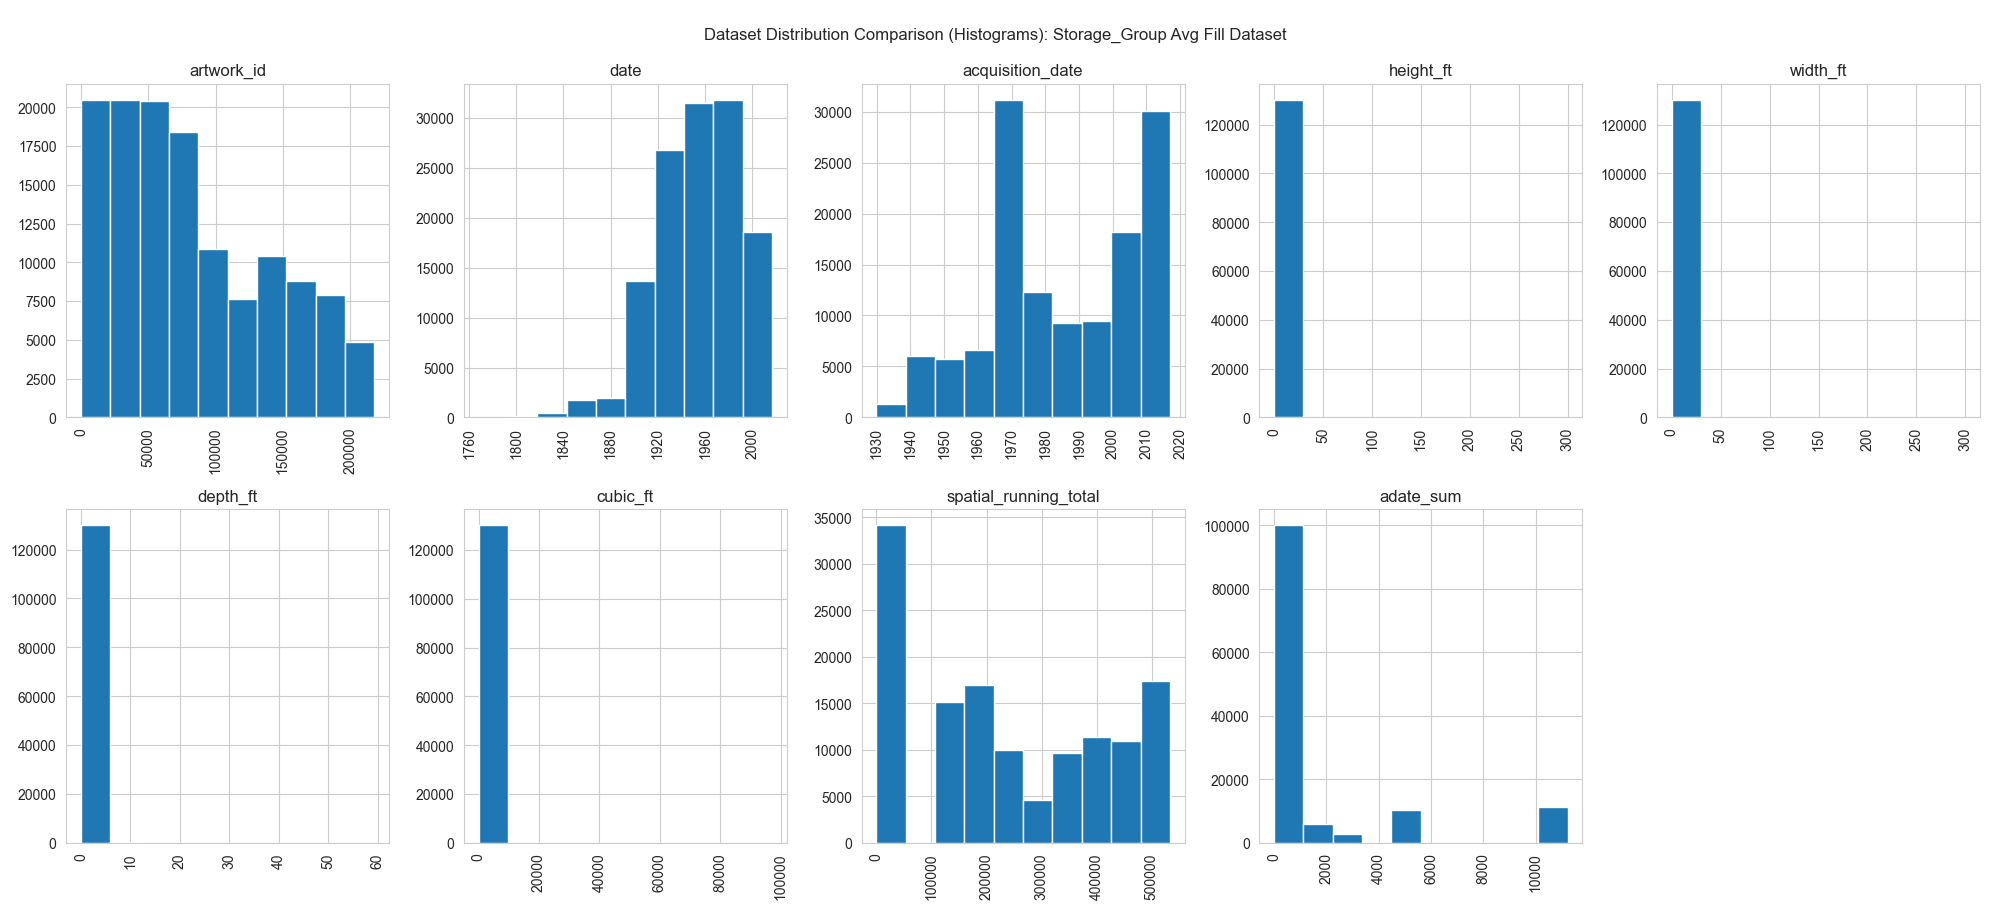

In [12]:
# Histograms
for file in datasets:
    title = file.replace("-", " ").title()
    datasets[file].hist(figsize=(20, 13), xrot=90, layout=(3, 5))
    plt.suptitle(f"\nDataset Distribution Comparison (Histograms): {title}\n")
    plt.tight_layout()
    plt.show()

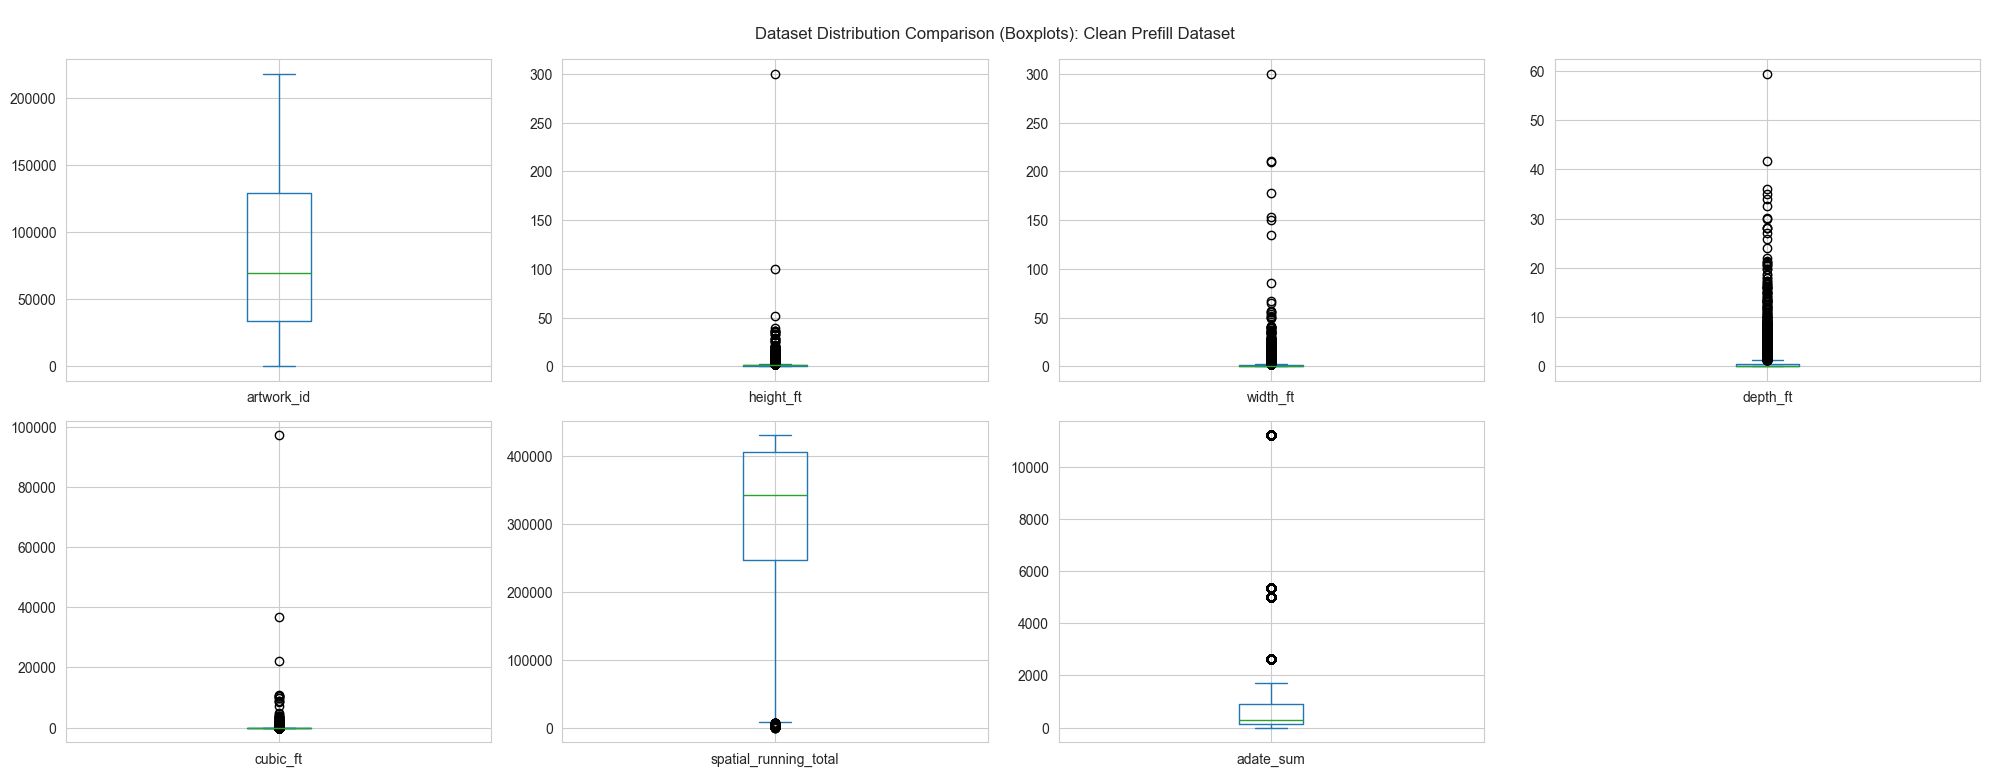

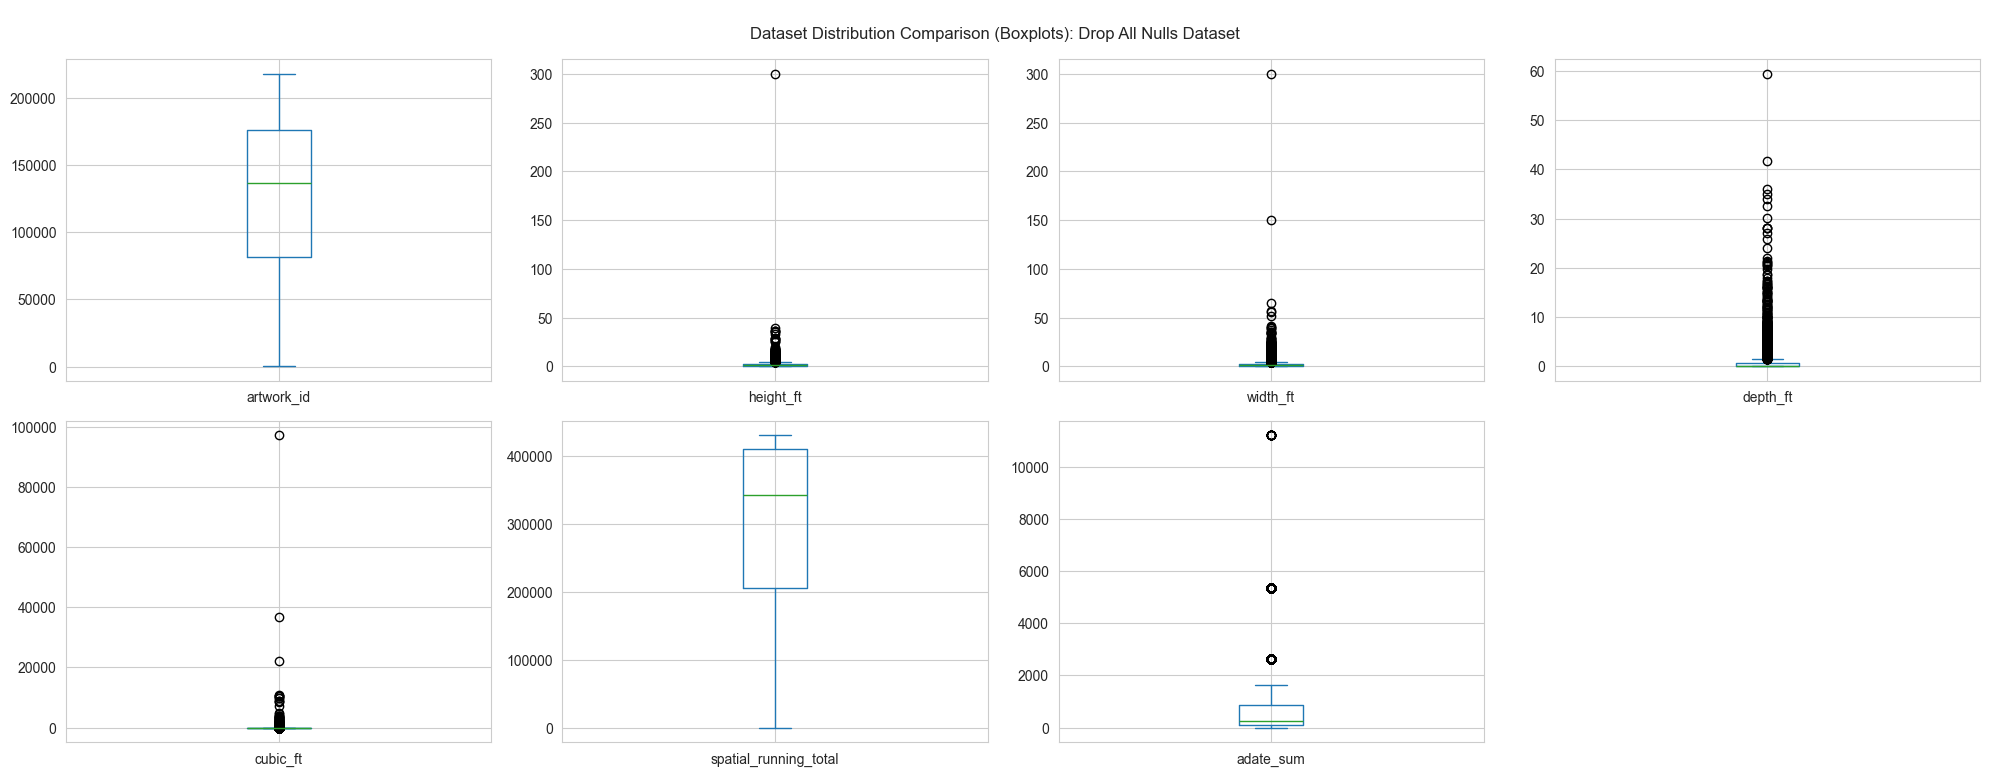

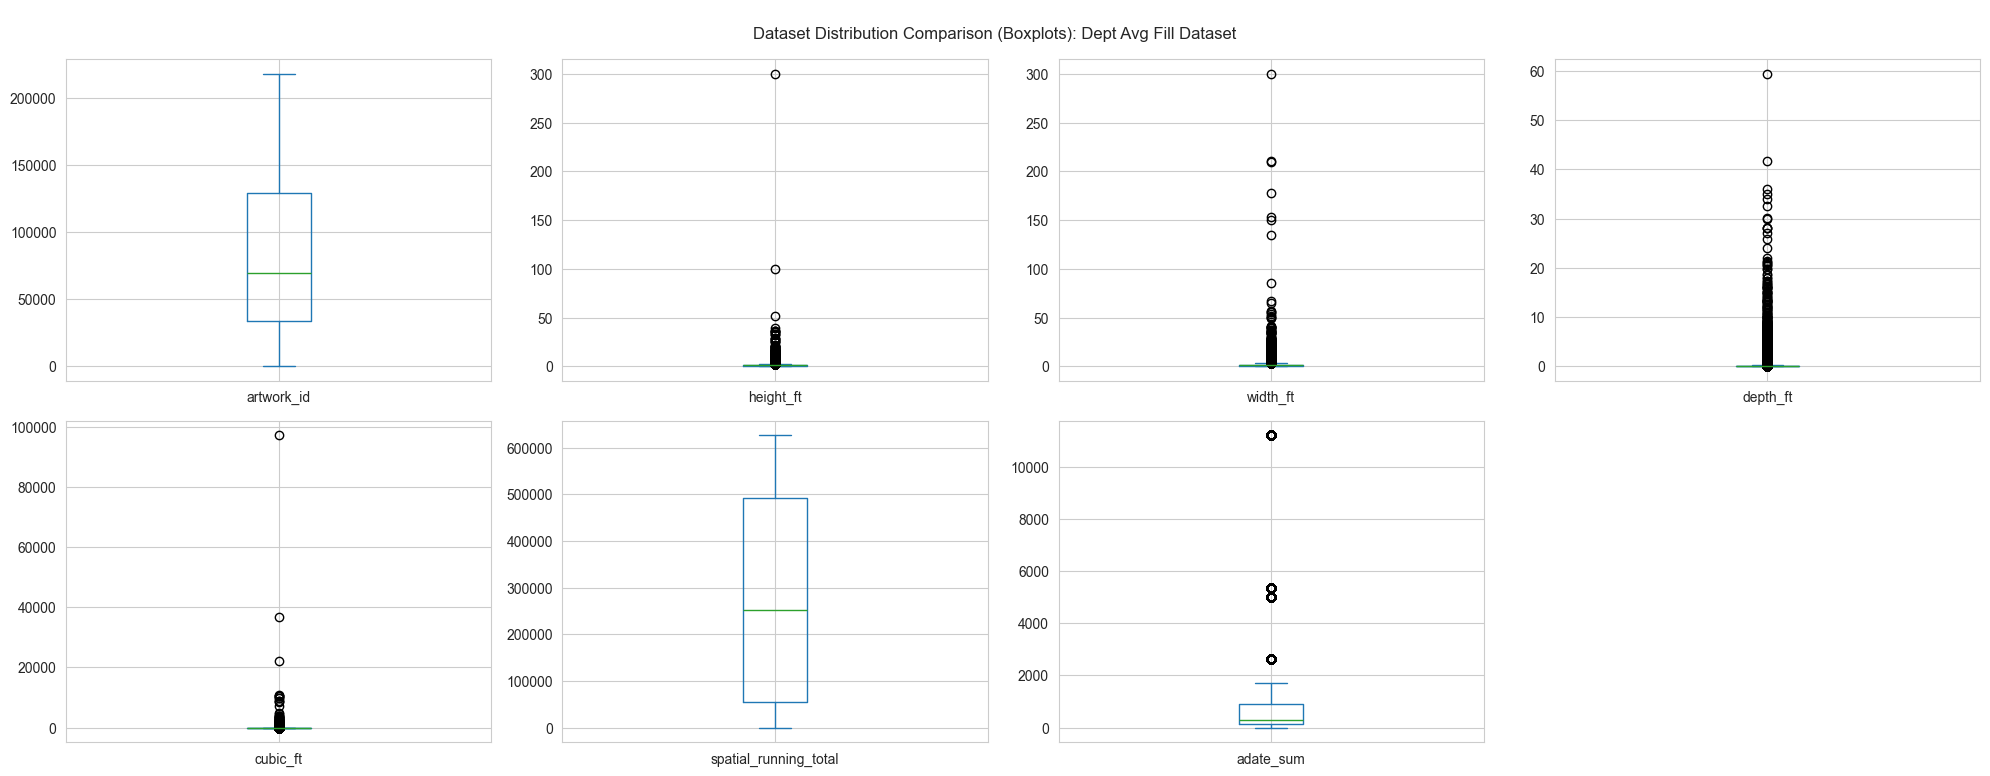

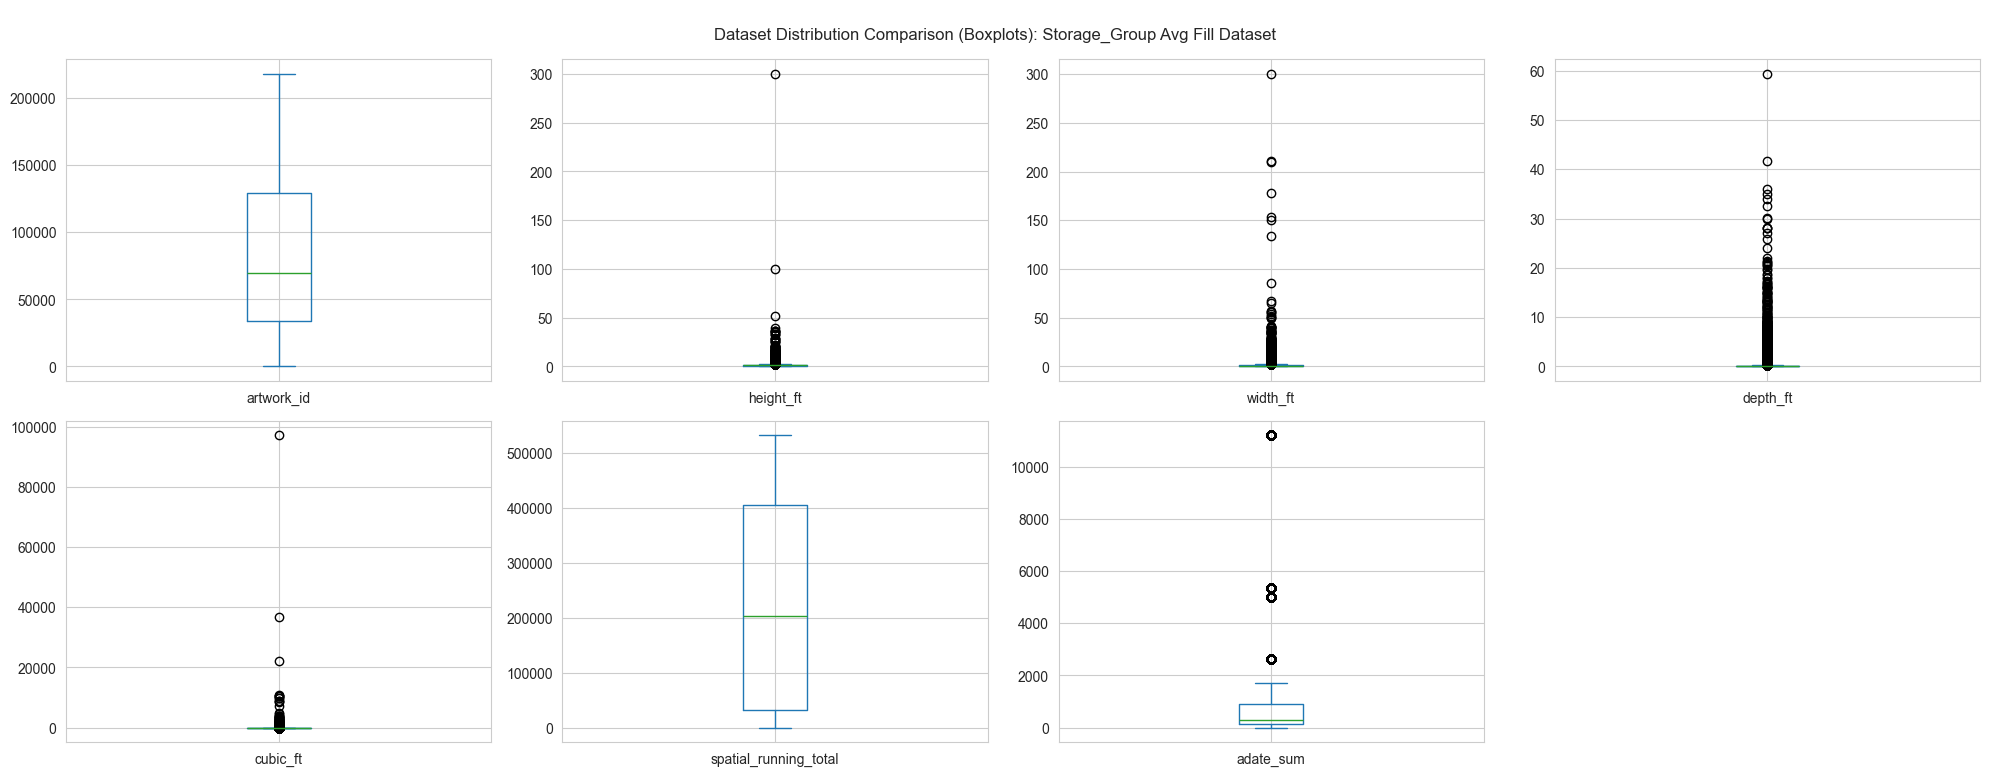

In [13]:
# Boxplots
for file in datasets:
    title = file.replace("-", " ").title()
    datasets[file].plot(figsize=(20, 15), kind="box", subplots=True, layout=(4, 4))
    plt.suptitle(f"\nDataset Distribution Comparison (Boxplots): {title}\n")
    plt.tight_layout()
    plt.show()

<section id="conclusions">
    <h2>Conclusions & Recommendations</h2>
</section>

### Final Thoughts

### Conclusions

In [14]:
datasets["storage_group-avg-fill-dataset"].to_csv("./out/datasets/NYC-MoMA-storage_group-fill.csv")